In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

!conda run -n base python3 -m pip install -q git+https://github.com/landerlini/FastQuantileLayer.git --force-reinstall --no-deps

2022-12-05 06:02:24.105988: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [17]:
test_dataset = tf.data.experimental.load("./acceptance-test.tfrecords").batch(1_000_000)
acceptance_model = tf.keras.models.load_model("/workarea/cloud-storage/anderlinil/models/acceptance")
y_hat = acceptance_model.predict(test_dataset)

acceptance_model.summary()

1/1 [==============================] - 2s 2s/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fast_quantile_layer (FastQu  (None, 10)               0         
 antileLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
      

In [18]:
X, y = next(iter(test_dataset.as_numpy_iterator()))
#acceptance_vars = ["mc_x", "mc_y", "mc_z", "mc_p", "mc_px", "mc_py", "mc_is_e", "mc_is_mu", "mc_is_h", "mc_charge"]

df = pd.DataFrame(
    np.c_[X, y, y_hat],
    columns=['x',' y', 'z', 'p', 'px', 'py', 'pz', 'is_e', 'is_mu', 'is_h', 'acceptance', 'predicted']
)
df.head(10)

,x,y,z,p,px,py,pz,is_e,is_mu,is_h,acceptance,predicted
0,147.257706,-134.657303,11301.966797,4760.291504,112.290001,-648.390015,0.0,0.0,1.0,-1.0,0.0,1.0
1,0.928800,-0.167900,67.115898,114789.437500,-113.160004,15.520000,0.0,0.0,1.0,1.0,0.0,1.0
2,0.928800,-0.167900,67.115898,6210.814941,-80.650002,-195.600006,0.0,0.0,1.0,1.0,1.0,1.0
3,0.928800,-0.167900,67.115898,25870.900391,-412.559998,583.460022,0.0,0.0,1.0,-1.0,1.0,1.0
4,0.928800,-0.167900,67.115898,10702.789062,14.690000,245.179993,0.0,0.0,1.0,1.0,1.0,1.0
5,0.928800,-0.167900,67.115898,48387.394531,369.089996,653.059998,0.0,0.0,1.0,1.0,1.0,1.0
6,20.291800,36.270199,2806.418213,2299.732666,262.119995,-526.900024,0.0,0.0,1.0,1.0,1.0,1.0
7,20.291800,36.270199,2806.418213,16622.189453,83.849998,422.440002,0.0,0.0,1.0,1.0,1.0,1.0
8,0.928800,-0.167900,67.115898,59095.210938,-273.019989,1150.020020,0.0,0.0,1.0,1.0,1.0,1.0
9,0.928800,-0.167900,67.115898,60590.968750,276.239990,-1087.349976,0.0,0.0,1.0,-1.0,1.0,1.0


In [19]:
acceptance_model = tf.keras.models.load_model("/workarea/cloud-storage/anderlinil/models/acceptance")
y_hat = acceptance_model.predict(X, batch_size=100_000)

2/2 [==============================] - 0s 24ms/step


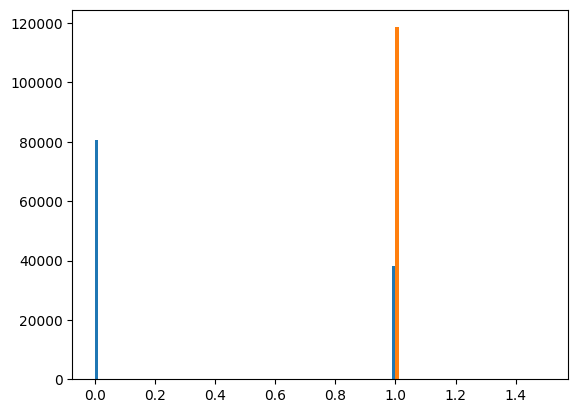

In [20]:
plt.hist(df.acceptance, bins=100, label="In Acceptance")
plt.hist(df.predicted, bins = 100, label="Predicted")
plt.show()